In [3]:
import os, glob, json, math, random
import numpy as np
from collections import defaultdict

# ★ 사용자 설정
PROJECT_TAG   = "v2"   # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()         # 노트북 위치 기준 (원하면 바꿔도 됨)
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN            = 45   # 3초 창 (추천)
STRIDE             = 15   # 1초 간격 (66% overlap, 안정적)
MIN_ACTIVE_RATIO   = 0.20 # 창 내에서 '손이 검출된 프레임' 비율 하한 (0.0~1.0)
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)


In [4]:
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir): 
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir): 
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            T, F = (arr.shape[0], arr.shape[1]) if arr.ndim==2 else (0,0)
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

len(manifest), manifest[:2]


(656,
 [{'label': '왼쪽-협측',
   'y': 0,
   'person': 'P01',
   'path': 'd:\\Final_Team3\\v2\\data_v2\\왼쪽-협측\\P01\\1755673634.npy',
   'T': 150,
   'F': 48},
  {'label': '왼쪽-협측',
   'y': 0,
   'person': 'P01',
   'path': 'd:\\Final_Team3\\v2\\data_v2\\왼쪽-협측\\P01\\1755674027.npy',
   'T': 150,
   'F': 48}])

In [5]:
from statistics import mean

feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)


Feature dims found: [48]
Clips: 656, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 48


In [6]:
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)   # 손 좌표 에너지
    return (e > eps).astype(np.float32)[:, None]


def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F)
    반환: [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    # 끝이 애매하면 마지막 창 하나 더 (중복 방지)
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (seq_len, F)
    손 좌표(앞 hand_dims)를 frame별로 검사하여
    non-zero 프레임 비율을 반환.
    """
    H = hand_dims
    hand = win[:, :H]              # (L, 42)
    # 프레임별 norm (21점×2를 묶어서 한 프레임 에너지로)
    fr = hand.reshape(win.shape[0], -1)
    nz = (np.abs(fr).sum(axis=1) > eps)  # 각 프레임에 손 검출 여부
    return nz.mean()


In [7]:
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue

    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                               # (L, F)  원본(스케일 전)
            M.append(frame_active_mask(w))           # (L, 1)  스케일 X
            y.append(m["y"])
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)
y = np.array(y)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)


Windows kept: 5248, dropped_short: 0, dropped_inactive: 0
X shape: (5248, 45, 48) M shape: (5248, 45, 1) y shape: (5248,)


In [8]:
# === LOSO 분할 + 스케일링 (모델 학습 없이) ===
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
import numpy as np

# 윈도우별 사람 ID
persons = np.array([m["person"] for m in meta])  # 길이 N (X, y와 동일한 첫 축)

F = X.shape[-1]
# 손 좌표가 앞 42차원(21점 x,y)일 때 fit 마스킹에 사용
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7

logo = LeaveOneGroupOut()
fold_no = 0

# 필요하면 결과를 모으고 싶을 때 사용 (메모리 고려해서 주석 유지 가능)
# all_folds = []

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1

    # Split
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    persons_train, persons_val = persons[train_idx], persons[val_idx]

    # --- 스케일러: train으로만 fit ---
    scaler = StandardScaler(with_mean=True, with_std=True)

    Xtr_flat = X_train.reshape(-1, F)
    # 손이 아예 미검출(제로필)인 프레임은 fit에서 제외해 통계 왜곡 방지 (옵션)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    if mask.any():
        scaler.fit(Xtr_flat[mask])
    else:
        # 드물지만 전부 제로인 경우를 대비한 fallback
        scaler.fit(Xtr_flat)

    # transform
    X_train_s = scaler.transform(Xtr_flat).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

    print(f"[LOSO Fold {fold_no}] "
          f"Train {X_train_s.shape}, Val {X_val_s.shape} | "
          f"persons train={len(set(persons_train))}, val={len(set(persons_val))}")

[LOSO Fold 1] Train (4728, 45, 48), Val (520, 45, 48) | persons train=21, val=1
[LOSO Fold 2] Train (4728, 45, 48), Val (520, 45, 48) | persons train=21, val=1
[LOSO Fold 3] Train (4936, 45, 48), Val (312, 45, 48) | persons train=21, val=1
[LOSO Fold 4] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 5] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 6] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 7] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 8] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 9] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 10] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 11] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 12] Train (5048, 45, 48), Val (200, 45, 48) | persons train=21, val=1
[LOSO Fold 13] Train (5072, 45, 48), 

In [9]:
import tensorflow as tf, gc, os
# (선택) GPU 메모리 점진 할당
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("set_memory_growth 실패:", e)


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

def _fixed_time_derivatives_with_mask(x, m):
    # x: (B,T,F)  // 스케일된 좌표
    # m: (B,T,1)  // 스케일 전 0/1 마스크
    x_prev = tf.pad(x[:, :-1, :], [[0,0],[1,0],[0,0]])
    dx = x - x_prev

    dx_prev = tf.pad(dx[:, :-1, :], [[0,0],[1,0],[0,0]])
    ddx = dx - dx_prev

    # 정의상 첫/두 프레임 0
    dx  = tf.concat([tf.zeros_like(dx[:, :1, :]),  dx[:, 1:, :]], axis=1)
    ddx = tf.concat([tf.zeros_like(ddx[:, :2, :]), ddx[:, 2:, :]], axis=1)

    # 게이팅은 "마스크"로 (스케일 영향 없음)
    gate_dx  = tf.concat([tf.zeros_like(m[:, :1, :]),  m[:, 1:, :]], axis=1)
    gate_ddx = tf.concat([tf.zeros_like(m[:, :2, :]), m[:, 2:, :]], axis=1)
    dx  = dx  * gate_dx
    ddx = ddx * gate_ddx

    return tf.concat([x, dx, ddx], axis=-1)  # (B,T,3F)

def build_gru_model_updown_with_diffs(input_shape, n_classes=2):
    L, F = input_shape
    inp_x = layers.Input(shape=(L, F), name="inp_x")   # 스케일된 (L,F)
    inp_m = layers.Input(shape=(L, 1), name="inp_m")   # 0/1 마스크

    # Δ/Δ² 부착
    x = layers.Lambda(lambda z: _fixed_time_derivatives_with_mask(z[0], z[1]),
                      name="fixed_diffs")([inp_x, inp_m])     # (L, 3F)

    # (선택) 1×1 Conv로 채널 압축 144→64
    x = layers.Conv1D(64, 1, padding='same', use_bias=False)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout1D(0.3)(x)

    # RNN 헤드 (용량/규제 밸런스)
    x = layers.GRU(64, dropout=0.5, recurrent_dropout=0.0,
                   kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model([inp_x, inp_m], out)

    opt = tf.keras.optimizers.Adam(learning_rate=5e-5, clipnorm=1.0)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


[Filter] 총 5248개 중 4016개 사용.  M shape: (4016, 45, 1),  분포: [2000 2016]
Epoch 1/80
57/57 [==============================] - 2s 14ms/step - loss: 0.9541 - accuracy: 0.5130 - val_loss: 0.7070 - val_accuracy: 0.6000 - lr: 5.0000e-05
Epoch 2/80
57/57 [==============================] - 0s 6ms/step - loss: 0.8856 - accuracy: 0.5177 - val_loss: 0.6493 - val_accuracy: 0.6225 - lr: 5.0000e-05
Epoch 3/80
57/57 [==============================] - 0s 7ms/step - loss: 0.8331 - accuracy: 0.5476 - val_loss: 0.6179 - val_accuracy: 0.6475 - lr: 5.0000e-05
Epoch 4/80
57/57 [==============================] - 0s 6ms/step - loss: 0.8060 - accuracy: 0.5456 - val_loss: 0.5961 - val_accuracy: 0.6650 - lr: 5.0000e-05
Epoch 5/80
57/57 [==============================] - 0s 7ms/step - loss: 0.7803 - accuracy: 0.5564 - val_loss: 0.5852 - val_accuracy: 0.6800 - lr: 5.0000e-05
Epoch 6/80
57/57 [==============================] - 0s 7ms/step - loss: 0.7527 - accuracy: 0.5783 - val_loss: 0.5791 - val_accuracy: 0.6775 - l

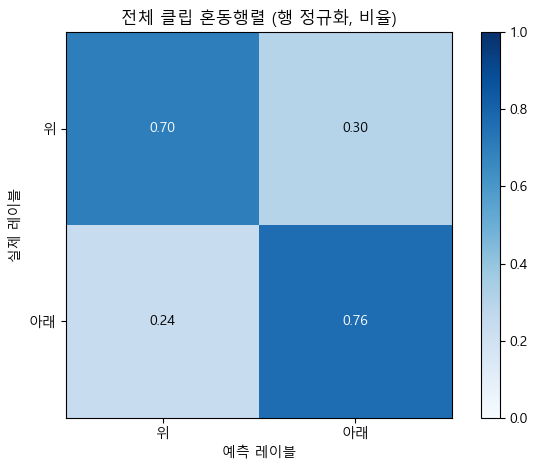

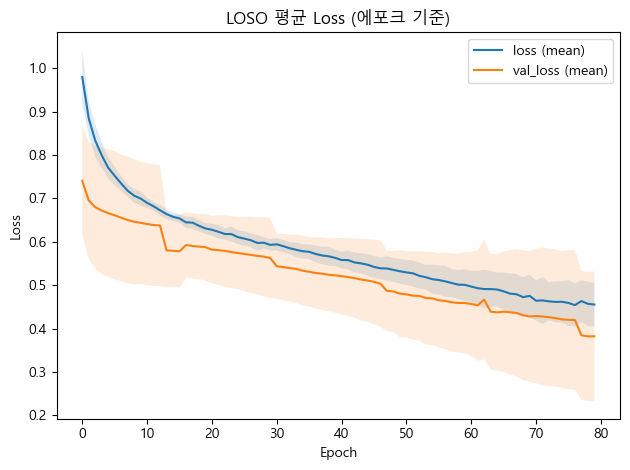

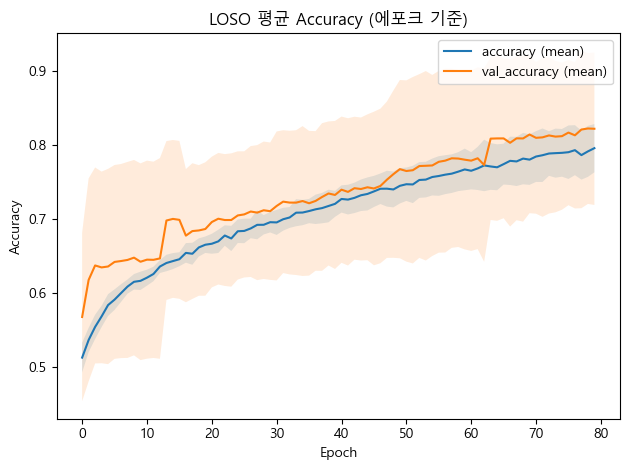

In [31]:
# =========================
# 위/아래 2-class LOSO 학습/평가 (평균 곡선 포함)
# =========================

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# ===== 옵션 =====
EPOCHS = 80
BATCH_SIZE = 64
ES_PATIENCE = 12
RLR_PATIENCE = 6

PLOT_LAST_FOLD_CURVES = True   # 폴드 개별 곡선(마지막 폴드만)
EVAL_LEVEL = "clip"            # "clip" 또는 "window"

# ===== 한글 폰트 =====
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

# ===== 시각화 헬퍼 =====
def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

# ----- 폴드 평균 곡선 -----
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    # Loss
    mean_loss, std_loss         = _nanmean_along_epochs([h.get('loss', []) for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h.get('val_loss', []) for h in histories])

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy']     for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ===== 13 → 2 (위/아래) 매핑 및 데이터 필터 =====
#  - 위(0): '구개측' 또는 '위-씹는면' 이 포함된 라벨
#  - 아래(1): '설측' 또는 '아래-씹는면' 이 포함된 라벨
#  - 그 외(예: '협측')는 제외
labels_np = np.array(KOREAN_LABELS, dtype=object)

def _ud_from_label(lab: str):
    if ('구개측' in lab) or ('위-씹는면' in lab):
        return 0  # 위
    if ('설측' in lab) or ('아래-씹는면' in lab):
        return 1  # 아래
    return None   # 제외(협측 등)

# 인덱스 마스크 생성
keep_indices = []
y_ud_list = []
for i, yi in enumerate(y):
    lab = labels_np[yi]
    mcls = _ud_from_label(lab)
    if mcls is not None:
        keep_indices.append(i)
        y_ud_list.append(mcls)

keep_indices = np.array(keep_indices, dtype=int)
X_ud = X[keep_indices]                 # (N_ud, L, F)
M_ud = M[keep_indices]                 # (N_ud, L, 1)  <- 추가
y_ud = np.array(y_ud_list, dtype=int)
meta_ud = [meta[i] for i in keep_indices]
persons_ud = np.array([m["person"] for m in meta_ud])

print(f"[Filter] 총 {len(X)}개 중 {len(X_ud)}개 사용.  M shape: {M_ud.shape},  분포:", np.bincount(y_ud))


# ===== LOSO 학습/평가 =====
F = X_ud.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7
logo = LeaveOneGroupOut()

CLASS_NAMES = ['위','아래']

# 집계 버퍼
histories = []
all_win_true, all_win_pred = [], []
all_clip_true, all_clip_pred = [], []
all_win_acc, all_clip_acc = [], []

fold_no = 0
total_folds = len(np.unique(persons_ud))

for train_idx, val_idx in logo.split(X_ud, y_ud, groups=persons_ud):
    X_train, y_train = X_ud[train_idx], y_ud[train_idx]
    X_val,   y_val   = X_ud[val_idx],   y_ud[val_idx]
    M_train, M_val   = M_ud[train_idx], M_ud[val_idx]     # ← 추가

    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)

    X_train_s = scaler.transform(X_train.reshape(-1, F)).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)
    # M_train, M_val 는 스케일링 절대 금지 (0/1 유지)

    # 모델
    model = build_gru_model_updown_with_diffs(
    input_shape=(X_train_s.shape[1], X_train_s.shape[2]),
    n_classes=2
    )
    
    cls_counts = np.bincount(y_train, minlength=2)
    class_weights = {i: float(np.median(cls_counts)/c) for i, c in enumerate(cls_counts)}

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
    ]

    history = model.fit(
        [X_train_s, M_train], y_train,
        validation_data=([X_val_s, M_val], y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=cb, verbose=1
    )
    histories.append(history.history)

    if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
        plot_training_curves(history, fold_no)

    # 윈도우 단위
    p = model.predict([X_val_s, M_val], verbose=0)
    y_pred = p.argmax(1)
    win_acc = accuracy_score(y_val, y_pred)
    all_win_acc.append(win_acc)
    all_win_true.append(y_val); all_win_pred.append(y_pred)

    # 클립 단위
    bucket_p, bucket_y = defaultdict(list), {}
    val_meta = [meta_ud[i] for i in val_idx]
    for i, m in enumerate(val_meta):
        bucket_p[m["src"]].append(p[i])
        bucket_y[m["src"]] = y_val[i]
    P_clip, Y_clip = [], []
    for src, ps in bucket_p.items():
        P_clip.append(np.mean(ps, axis=0))
        Y_clip.append(bucket_y[src])
    clip_pred = np.argmax(np.vstack(P_clip), axis=1)
    clip_acc = accuracy_score(Y_clip, clip_pred)
    all_clip_acc.append(clip_acc)
    all_clip_true.append(np.array(Y_clip))
    all_clip_pred.append(clip_pred)

# ===== 폴드 전체 집계 =====
all_win_true  = np.concatenate(all_win_true, axis=0)
all_win_pred  = np.concatenate(all_win_pred, axis=0)
all_clip_true = np.concatenate(all_clip_true, axis=0)
all_clip_pred = np.concatenate(all_clip_pred, axis=0)

print("\n==== LOSO Summary (Up/Down) ====")
print(f"Mean Window Acc: {np.mean(all_win_acc):.3f} ± {np.std(all_win_acc):.3f}")
print(f"Mean Clip   Acc: {np.mean(all_clip_acc):.3f} ± {np.std(all_clip_acc):.3f}")

# ===== 최종(전체 사람) 혼동행렬/지표 =====
if EVAL_LEVEL == "clip":
    y_true_overall = all_clip_true; y_pred_overall = all_clip_pred; level_name = "클립"
else:
    y_true_overall = all_win_true;  y_pred_overall = all_win_pred;  level_name = "윈도우"

overall_acc = accuracy_score(y_true_overall, y_pred_overall)
print(f"\n==== OVERALL ({level_name}) ====")
print(f"Overall {level_name} Acc: {overall_acc:.3f}")
print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1])
plot_confmat_ratio(cm_overall, CLASS_NAMES, f'전체 {level_name} 혼동행렬 (행 정규화, 비율)')

# ===== LOSO 평균 곡선 =====
plot_mean_training_curves(histories)


In [32]:
# 윈도 단위 활성 비율 점검
ratios = (M.reshape(M.shape[0], -1).mean(axis=1))  # 각 윈도의 활성 비율
print("median active ratio:", np.median(ratios), " 10/90pct:",
      np.percentile(ratios,[10,90]))


median active ratio: 1.0  10/90pct: [1. 1.]


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

def _fixed_delta_with_mask(x, m):
    # x: (B,T,F), m: (B,T,1)  [여기선 m≡1에 가까워도 괜찮]
    x_prev = tf.pad(x[:, :-1, :], [[0,0],[1,0],[0,0]])
    dx = x - x_prev
    dx = tf.concat([tf.zeros_like(dx[:, :1, :]), dx[:, 1:, :]], axis=1)
    gate_dx = tf.concat([tf.zeros_like(m[:, :1, :]), m[:, 1:, :]], axis=1)
    dx *= gate_dx
    return x, dx

def build_updown_x_plus_delta(input_shape, n_classes=2):
    L, F = input_shape
    inp_x = layers.Input((L, F),  name="inp_x")
    inp_m = layers.Input((L, 1),  name="inp_m")   # m은 지금 거의 1이지만 인터페이스 유지

    # x, Δ 생성
    x, dx = layers.Lambda(lambda z: _fixed_delta_with_mask(z[0], z[1]))([inp_x, inp_m])

    # 그룹별 정규화 후 결합 (분포 안정화)
    x  = layers.LayerNormalization()(x)
    dx = layers.LayerNormalization()(dx)
    feat = layers.Concatenate(axis=-1)([x, dx])   # (L, 2F)

    # 1x1 Conv로 채널 압축/혼합
    feat = layers.Conv1D(128, 1, padding='same', use_bias=False)(feat)
    feat = layers.LayerNormalization()(feat)
    feat = layers.Activation('relu')(feat)
    feat = layers.SpatialDropout1D(0.15)(feat)

    # RNN 헤드 (용량 ↑, 규제 완화)
    h = layers.GRU(96, dropout=0.3, recurrent_dropout=0.0,
                   kernel_regularizer=regularizers.l2(5e-5))(feat)
    h = layers.LayerNormalization()(h)
    h = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(5e-5))(h)
    h = layers.Dropout(0.4)(h)

    out = layers.Dense(n_classes, activation='softmax')(h)
    model = tf.keras.Model([inp_x, inp_m], out)

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


[Filter] 총 5248개 중 4016개 사용.  M shape: (4016, 45, 1),  분포: [2000 2016]
Epoch 1/80
57/57 [==============================] - 2s 14ms/step - loss: 0.7350 - accuracy: 0.6004 - val_loss: 0.5670 - val_accuracy: 0.6675 - lr: 3.0000e-04
Epoch 2/80
57/57 [==============================] - 0s 7ms/step - loss: 0.6207 - accuracy: 0.6723 - val_loss: 0.5910 - val_accuracy: 0.7200 - lr: 3.0000e-04
Epoch 3/80
57/57 [==============================] - 0s 7ms/step - loss: 0.5740 - accuracy: 0.7174 - val_loss: 0.6131 - val_accuracy: 0.7350 - lr: 3.0000e-04
Epoch 4/80
57/57 [==============================] - 0s 6ms/step - loss: 0.5485 - accuracy: 0.7243 - val_loss: 0.7392 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 5/80
57/57 [==============================] - 0s 7ms/step - loss: 0.5120 - accuracy: 0.7575 - val_loss: 0.7969 - val_accuracy: 0.7000 - lr: 3.0000e-04
Epoch 6/80
57/57 [==============================] - 0s 6ms/step - loss: 0.4736 - accuracy: 0.7771 - val_loss: 1.0901 - val_accuracy: 0.6150 - l

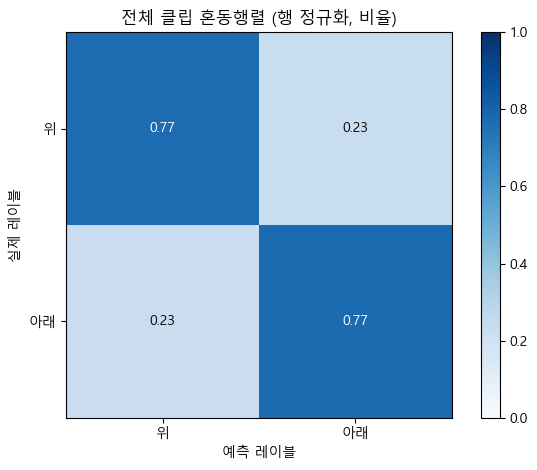

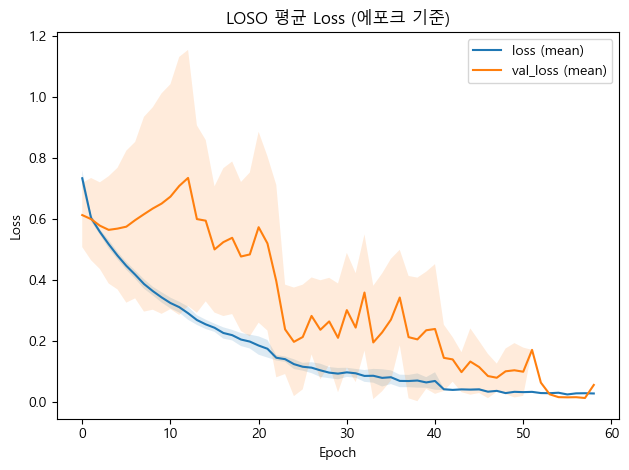

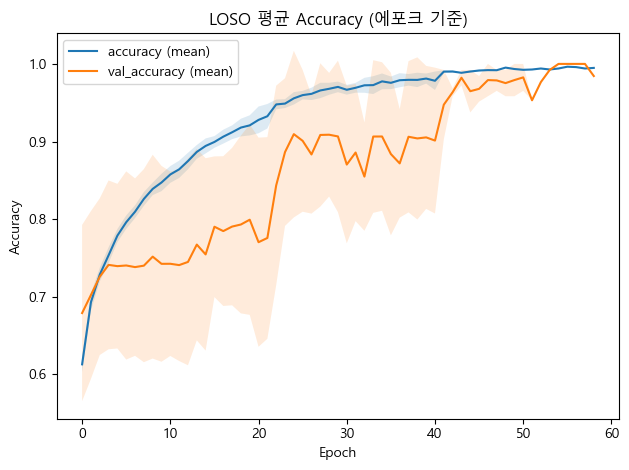

In [34]:
# =========================
# 위/아래 2-class LOSO 학습/평가 (평균 곡선 포함)
# =========================

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# ===== 옵션 =====
EPOCHS = 80
BATCH_SIZE = 64
ES_PATIENCE = 12
RLR_PATIENCE = 6

PLOT_LAST_FOLD_CURVES = True   # 폴드 개별 곡선(마지막 폴드만)
EVAL_LEVEL = "clip"            # "clip" 또는 "window"

# ===== 한글 폰트 =====
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

# ===== 시각화 헬퍼 =====
def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

# ----- 폴드 평균 곡선 -----
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    # Loss
    mean_loss, std_loss         = _nanmean_along_epochs([h.get('loss', []) for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h.get('val_loss', []) for h in histories])

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy']     for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ===== 13 → 2 (위/아래) 매핑 및 데이터 필터 =====
#  - 위(0): '구개측' 또는 '위-씹는면' 이 포함된 라벨
#  - 아래(1): '설측' 또는 '아래-씹는면' 이 포함된 라벨
#  - 그 외(예: '협측')는 제외
labels_np = np.array(KOREAN_LABELS, dtype=object)

def _ud_from_label(lab: str):
    if ('구개측' in lab) or ('위-씹는면' in lab):
        return 0  # 위
    if ('설측' in lab) or ('아래-씹는면' in lab):
        return 1  # 아래
    return None   # 제외(협측 등)

# 인덱스 마스크 생성
keep_indices = []
y_ud_list = []
for i, yi in enumerate(y):
    lab = labels_np[yi]
    mcls = _ud_from_label(lab)
    if mcls is not None:
        keep_indices.append(i)
        y_ud_list.append(mcls)

keep_indices = np.array(keep_indices, dtype=int)
X_ud = X[keep_indices]                 # (N_ud, L, F)
M_ud = M[keep_indices]                 # (N_ud, L, 1)  <- 추가
y_ud = np.array(y_ud_list, dtype=int)
meta_ud = [meta[i] for i in keep_indices]
persons_ud = np.array([m["person"] for m in meta_ud])

print(f"[Filter] 총 {len(X)}개 중 {len(X_ud)}개 사용.  M shape: {M_ud.shape},  분포:", np.bincount(y_ud))


# ===== LOSO 학습/평가 =====
F = X_ud.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7
logo = LeaveOneGroupOut()

CLASS_NAMES = ['위','아래']

# 집계 버퍼
histories = []
all_win_true, all_win_pred = [], []
all_clip_true, all_clip_pred = [], []
all_win_acc, all_clip_acc = [], []

fold_no = 0
total_folds = len(np.unique(persons_ud))

for train_idx, val_idx in logo.split(X_ud, y_ud, groups=persons_ud):
    X_train, y_train = X_ud[train_idx], y_ud[train_idx]
    X_val,   y_val   = X_ud[val_idx],   y_ud[val_idx]
    M_train, M_val   = M_ud[train_idx], M_ud[val_idx]     # ← 추가

    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)

    X_train_s = scaler.transform(X_train.reshape(-1, F)).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)
    # M_train, M_val 는 스케일링 절대 금지 (0/1 유지)

    # 모델
    model = build_updown_x_plus_delta(
    input_shape=(X_train_s.shape[1], X_train_s.shape[2]),
    n_classes=2
    )
    
    cls_counts = np.bincount(y_train, minlength=2)
    class_weights = {i: float(np.median(cls_counts)/c) for i, c in enumerate(cls_counts)}

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
    ]

    history = model.fit(
        [X_train_s, M_train], y_train,
        validation_data=([X_val_s, M_val], y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=cb, verbose=1
    )
    histories.append(history.history)

    if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
        plot_training_curves(history, fold_no)

    # 윈도우 단위
    p = model.predict([X_val_s, M_val], verbose=0)
    y_pred = p.argmax(1)
    win_acc = accuracy_score(y_val, y_pred)
    all_win_acc.append(win_acc)
    all_win_true.append(y_val); all_win_pred.append(y_pred)

    # 클립 단위
    bucket_p, bucket_y = defaultdict(list), {}
    val_meta = [meta_ud[i] for i in val_idx]
    for i, m in enumerate(val_meta):
        bucket_p[m["src"]].append(p[i])
        bucket_y[m["src"]] = y_val[i]
    P_clip, Y_clip = [], []
    for src, ps in bucket_p.items():
        P_clip.append(np.mean(ps, axis=0))
        Y_clip.append(bucket_y[src])
    clip_pred = np.argmax(np.vstack(P_clip), axis=1)
    clip_acc = accuracy_score(Y_clip, clip_pred)
    all_clip_acc.append(clip_acc)
    all_clip_true.append(np.array(Y_clip))
    all_clip_pred.append(clip_pred)

# ===== 폴드 전체 집계 =====
all_win_true  = np.concatenate(all_win_true, axis=0)
all_win_pred  = np.concatenate(all_win_pred, axis=0)
all_clip_true = np.concatenate(all_clip_true, axis=0)
all_clip_pred = np.concatenate(all_clip_pred, axis=0)

print("\n==== LOSO Summary (Up/Down) ====")
print(f"Mean Window Acc: {np.mean(all_win_acc):.3f} ± {np.std(all_win_acc):.3f}")
print(f"Mean Clip   Acc: {np.mean(all_clip_acc):.3f} ± {np.std(all_clip_acc):.3f}")

# ===== 최종(전체 사람) 혼동행렬/지표 =====
if EVAL_LEVEL == "clip":
    y_true_overall = all_clip_true; y_pred_overall = all_clip_pred; level_name = "클립"
else:
    y_true_overall = all_win_true;  y_pred_overall = all_win_pred;  level_name = "윈도우"

overall_acc = accuracy_score(y_true_overall, y_pred_overall)
print(f"\n==== OVERALL ({level_name}) ====")
print(f"Overall {level_name} Acc: {overall_acc:.3f}")
print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1])
plot_confmat_ratio(cm_overall, CLASS_NAMES, f'전체 {level_name} 혼동행렬 (행 정규화, 비율)')

# ===== LOSO 평균 곡선 =====
plot_mean_training_curves(histories)


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# --- 그대로 재사용 ---
def _fixed_time_derivatives_with_mask(x, m):
    x_prev = tf.pad(x[:, :-1, :], [[0,0],[1,0],[0,0]])
    dx = x - x_prev
    dx_prev = tf.pad(dx[:, :-1, :], [[0,0],[1,0],[0,0]])
    ddx = dx - dx_prev
    dx  = tf.concat([tf.zeros_like(dx[:, :1, :]),  dx[:, 1:, :]], axis=1)
    ddx = tf.concat([tf.zeros_like(ddx[:, :2, :]), ddx[:, 2:, :]], axis=1)

    gate_dx  = tf.concat([tf.zeros_like(m[:, :1, :]),  m[:, 1:, :]], axis=1)
    gate_ddx = tf.concat([tf.zeros_like(m[:, :2, :]), m[:, 2:, :]], axis=1)
    dx  = dx  * gate_dx
    ddx = ddx * gate_ddx
    return tf.concat([x, dx, ddx], axis=-1)  # (B,T,3F)

def build_hybrid_cnn_gru_updown(input_shape, n_classes=2,
                                base_ch=64,   # CNN 채널 폭
                                k=5,          # 커널 크기
                                gru_units=64, # 첫 GRU 유닛
                                l2=1e-4,
                                p_spatial=0.2,
                                p_drop=0.5,
                                lr=5e-5):
    """
    입력: inp_x=(L,F) (스케일된 좌표), inp_m=(L,1) (0/1 마스크)
    블록: [Δ/Δ² 부착] -> [1×1 bottleneck] -> [Separable TConv × 3 (dilation=1,2,4, residual)]
        -> SpatialDropout -> [GRU(64, rs=True) -> GRU(32)] -> 마스크드 어텐션 -> Dense
    """
    L, F = input_shape
    inp_x = layers.Input(shape=(L, F), name="inp_x")
    inp_m = layers.Input(shape=(L, 1), name="inp_m")   # 0/1

    # 1) Δ/Δ² 부착
    x = layers.Lambda(lambda z: _fixed_time_derivatives_with_mask(z[0], z[1]),
                      name="fixed_diffs")([inp_x, inp_m])      # (B,T,3F)

    # 2) 1×1 bottleneck로 채널 압축 (3F -> base_ch)
    x = layers.Conv1D(base_ch, 1, use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    # 3) 마스크로 비활성 프레임 zero-out (CNN/GRU 모두에 적용)
    x = layers.Multiply()([x, inp_m])

    # 4) 다이레이티드 Separable Temporal Convs (+Residual)
    def sep_block(x, dilation):
        shortcut = x
        y = layers.SeparableConv1D(base_ch, k, padding='same', dilation_rate=dilation,
                                   depthwise_regularizer=regularizers.l2(l2),
                                   pointwise_regularizer=regularizers.l2(l2),
                                   use_bias=False)(x)
        y = layers.LayerNormalization()(y)
        y = layers.Activation('relu')(y)
        y = layers.SeparableConv1D(base_ch, 1, padding='same', use_bias=False)(y)
        y = layers.LayerNormalization()(y)
        # Residual
        x = layers.Add()([shortcut, y])
        x = layers.Activation('relu')(x)
        return x

    x = sep_block(x, dilation=1)
    x = sep_block(x, dilation=2)
    x = sep_block(x, dilation=4)
    x = layers.SpatialDropout1D(p_spatial)(x)

    # 5) GRU 스택 (장기 의존성)
    x = layers.GRU(gru_units, return_sequences=True,
                   dropout=p_drop, recurrent_dropout=0.0,
                   kernel_regularizer=regularizers.l2(l2),
                   recurrent_regularizer=regularizers.l2(l2))(x)
    x = layers.GRU(gru_units//2, return_sequences=True,
                   dropout=p_drop, recurrent_dropout=0.0,
                   kernel_regularizer=regularizers.l2(l2),
                   recurrent_regularizer=regularizers.l2(l2))(x)

    # 6) 마스크드 어텐션 풀링 (가중 평균)
    # scores: (B,T,1)
    scores = layers.Dense(1, use_bias=False)(x)
    # 마스크가 0인 위치는 큰 음수로 가려서 softmax 제외
    very_neg = -1e9
    scores = layers.Add()([scores, (inp_m - 1.0) * very_neg])
    alpha = layers.Softmax(axis=1, name="attn_weights")(scores)      # (B,T,1)
    x = layers.Multiply()([x, alpha])                                # (B,T,C)
    x = tf.reduce_sum(x, axis=1)                                     # (B,C)

    # 7) 분류 헤드
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(p_drop)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model([inp_x, inp_m], out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


[Filter] 총 5248개 중 4016개 사용.  M shape: (4016, 45, 1),  분포: [2000 2016]
Epoch 1/80
57/57 [==============================] - 4s 24ms/step - loss: 0.8831 - accuracy: 0.5028 - val_loss: 0.7094 - val_accuracy: 0.6325 - lr: 5.0000e-05
Epoch 2/80
57/57 [==============================] - 1s 14ms/step - loss: 0.8024 - accuracy: 0.5216 - val_loss: 0.6881 - val_accuracy: 0.7925 - lr: 5.0000e-05
Epoch 3/80
57/57 [==============================] - 1s 14ms/step - loss: 0.7779 - accuracy: 0.5401 - val_loss: 0.6804 - val_accuracy: 0.8100 - lr: 5.0000e-05
Epoch 4/80
57/57 [==============================] - 1s 14ms/step - loss: 0.7526 - accuracy: 0.5639 - val_loss: 0.6772 - val_accuracy: 0.7800 - lr: 5.0000e-05
Epoch 5/80
57/57 [==============================] - 1s 14ms/step - loss: 0.7399 - accuracy: 0.5813 - val_loss: 0.6671 - val_accuracy: 0.7400 - lr: 5.0000e-05
Epoch 6/80
57/57 [==============================] - 1s 14ms/step - loss: 0.7233 - accuracy: 0.6065 - val_loss: 0.6531 - val_accuracy: 0.715

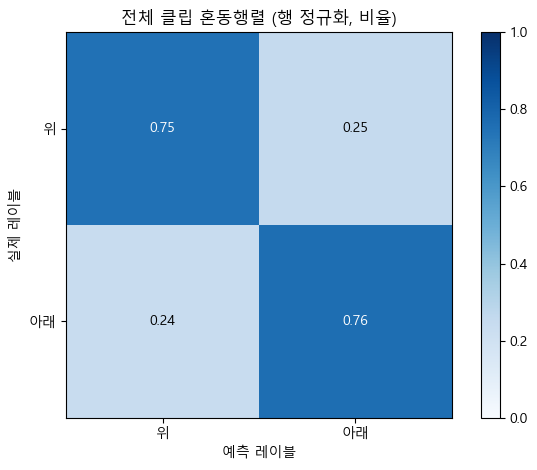

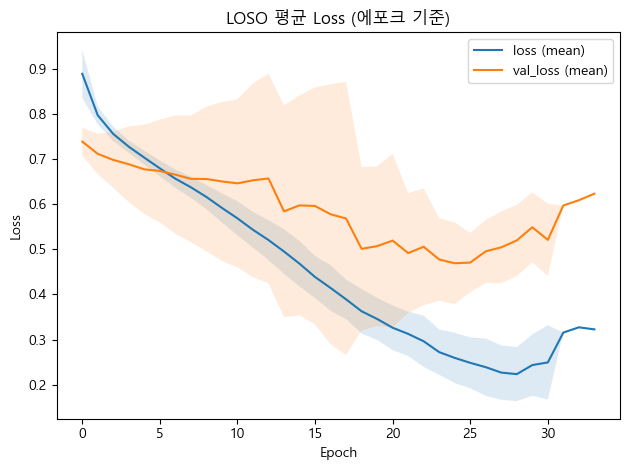

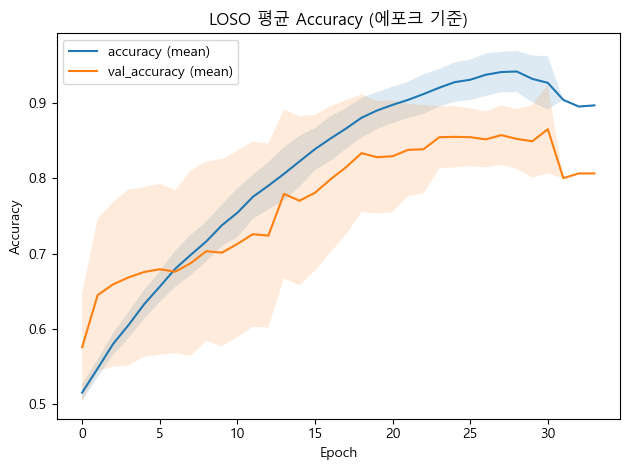

In [36]:
# =========================
# 위/아래 2-class LOSO 학습/평가 (평균 곡선 포함)
# =========================

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# ===== 옵션 =====
EPOCHS = 80
BATCH_SIZE = 64
ES_PATIENCE = 12
RLR_PATIENCE = 6

PLOT_LAST_FOLD_CURVES = True   # 폴드 개별 곡선(마지막 폴드만)
EVAL_LEVEL = "clip"            # "clip" 또는 "window"

# ===== 한글 폰트 =====
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

# ===== 시각화 헬퍼 =====
def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

# ----- 폴드 평균 곡선 -----
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    # Loss
    mean_loss, std_loss         = _nanmean_along_epochs([h.get('loss', []) for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h.get('val_loss', []) for h in histories])

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy']     for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ===== 13 → 2 (위/아래) 매핑 및 데이터 필터 =====
#  - 위(0): '구개측' 또는 '위-씹는면' 이 포함된 라벨
#  - 아래(1): '설측' 또는 '아래-씹는면' 이 포함된 라벨
#  - 그 외(예: '협측')는 제외
labels_np = np.array(KOREAN_LABELS, dtype=object)

def _ud_from_label(lab: str):
    if ('구개측' in lab) or ('위-씹는면' in lab):
        return 0  # 위
    if ('설측' in lab) or ('아래-씹는면' in lab):
        return 1  # 아래
    return None   # 제외(협측 등)

# 인덱스 마스크 생성
keep_indices = []
y_ud_list = []
for i, yi in enumerate(y):
    lab = labels_np[yi]
    mcls = _ud_from_label(lab)
    if mcls is not None:
        keep_indices.append(i)
        y_ud_list.append(mcls)

keep_indices = np.array(keep_indices, dtype=int)
X_ud = X[keep_indices]                 # (N_ud, L, F)
M_ud = M[keep_indices]                 # (N_ud, L, 1)  <- 추가
y_ud = np.array(y_ud_list, dtype=int)
meta_ud = [meta[i] for i in keep_indices]
persons_ud = np.array([m["person"] for m in meta_ud])

print(f"[Filter] 총 {len(X)}개 중 {len(X_ud)}개 사용.  M shape: {M_ud.shape},  분포:", np.bincount(y_ud))


# ===== LOSO 학습/평가 =====
F = X_ud.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7
logo = LeaveOneGroupOut()

CLASS_NAMES = ['위','아래']

# 집계 버퍼
histories = []
all_win_true, all_win_pred = [], []
all_clip_true, all_clip_pred = [], []
all_win_acc, all_clip_acc = [], []

fold_no = 0
total_folds = len(np.unique(persons_ud))

for train_idx, val_idx in logo.split(X_ud, y_ud, groups=persons_ud):
    X_train, y_train = X_ud[train_idx], y_ud[train_idx]
    X_val,   y_val   = X_ud[val_idx],   y_ud[val_idx]
    M_train, M_val   = M_ud[train_idx], M_ud[val_idx]     # ← 추가

    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)

    X_train_s = scaler.transform(X_train.reshape(-1, F)).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)
    # M_train, M_val 는 스케일링 절대 금지 (0/1 유지)

    # 모델
    model = build_hybrid_cnn_gru_updown(
    input_shape=(X_train_s.shape[1], X_train_s.shape[2]),
    n_classes=2
    )
    
    cls_counts = np.bincount(y_train, minlength=2)
    class_weights = {i: float(np.median(cls_counts)/c) for i, c in enumerate(cls_counts)}

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
    ]

    history = model.fit(
        [X_train_s, M_train], y_train,
        validation_data=([X_val_s, M_val], y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=cb, verbose=1
    )
    histories.append(history.history)

    if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
        plot_training_curves(history, fold_no)

    # 윈도우 단위
    p = model.predict([X_val_s, M_val], verbose=0)
    y_pred = p.argmax(1)
    win_acc = accuracy_score(y_val, y_pred)
    all_win_acc.append(win_acc)
    all_win_true.append(y_val); all_win_pred.append(y_pred)

    # 클립 단위
    bucket_p, bucket_y = defaultdict(list), {}
    val_meta = [meta_ud[i] for i in val_idx]
    for i, m in enumerate(val_meta):
        bucket_p[m["src"]].append(p[i])
        bucket_y[m["src"]] = y_val[i]
    P_clip, Y_clip = [], []
    for src, ps in bucket_p.items():
        P_clip.append(np.mean(ps, axis=0))
        Y_clip.append(bucket_y[src])
    clip_pred = np.argmax(np.vstack(P_clip), axis=1)
    clip_acc = accuracy_score(Y_clip, clip_pred)
    all_clip_acc.append(clip_acc)
    all_clip_true.append(np.array(Y_clip))
    all_clip_pred.append(clip_pred)

# ===== 폴드 전체 집계 =====
all_win_true  = np.concatenate(all_win_true, axis=0)
all_win_pred  = np.concatenate(all_win_pred, axis=0)
all_clip_true = np.concatenate(all_clip_true, axis=0)
all_clip_pred = np.concatenate(all_clip_pred, axis=0)

print("\n==== LOSO Summary (Up/Down) ====")
print(f"Mean Window Acc: {np.mean(all_win_acc):.3f} ± {np.std(all_win_acc):.3f}")
print(f"Mean Clip   Acc: {np.mean(all_clip_acc):.3f} ± {np.std(all_clip_acc):.3f}")

# ===== 최종(전체 사람) 혼동행렬/지표 =====
if EVAL_LEVEL == "clip":
    y_true_overall = all_clip_true; y_pred_overall = all_clip_pred; level_name = "클립"
else:
    y_true_overall = all_win_true;  y_pred_overall = all_win_pred;  level_name = "윈도우"

overall_acc = accuracy_score(y_true_overall, y_pred_overall)
print(f"\n==== OVERALL ({level_name}) ====")
print(f"Overall {level_name} Acc: {overall_acc:.3f}")
print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1])
plot_confmat_ratio(cm_overall, CLASS_NAMES, f'전체 {level_name} 혼동행렬 (행 정규화, 비율)')

# ===== LOSO 평균 곡선 =====
plot_mean_training_curves(histories)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

def build_crnn_with_delta(input_shape, n_classes=2,
                          k=5,        # Conv1D 커널(시간)
                          l2=1e-4,
                          ch1=64, ch2=128,
                          gru1=128, gru2=64,
                          p_drop_conv=0.30,
                          p_drop_dense=0.50,
                          lr=3e-4):
    """
    입력: (L, F)  -> 내부에서 Δ(1차) 생성 후 concat([x, Δ], axis=-1)
    블록: [Conv(64)->BN->ReLU->Drop] -> [Conv(128)->BN->ReLU->Drop]
          -> GRU(128, rs=True) -> GRU(64)
          -> Dense(64)->BN->ReLU->Drop -> Softmax
    """
    inp = layers.Input(shape=input_shape)      # (L, F)

    # --- Δ(1차) 생성 (레이어 안) ---
    def make_delta(x):
        x_prev = tf.pad(x[:, :-1, :], [[0,0],[1,0],[0,0]])
        dx = x - x_prev
        dx = tf.concat([tf.zeros_like(dx[:, :1, :]), dx[:, 1:, :]], axis=1)
        return tf.concat([x, dx], axis=-1)     # (L, 2F)
    x = layers.Lambda(make_delta, name="cat_x_delta")(inp)

    # --- Conv 블록 1 ---
    x = layers.Conv1D(ch1, k, padding='same',
                      kernel_regularizer=regularizers.l2(l2),
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(p_drop_conv)(x)

    # --- Conv 블록 2 ---
    x = layers.Conv1D(ch2, k, padding='same',
                      kernel_regularizer=regularizers.l2(l2),
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(p_drop_conv)(x)

    # --- GRU 블록 ---
    x = layers.GRU(gru1, return_sequences=True,
                   dropout=0.30, recurrent_dropout=0.0,
                   kernel_regularizer=regularizers.l2(l2),
                   recurrent_regularizer=regularizers.l2(l2))(x)
    x = layers.GRU(gru2,
                   dropout=0.30, recurrent_dropout=0.0,
                   kernel_regularizer=regularizers.l2(l2),
                   recurrent_regularizer=regularizers.l2(l2))(x)

    # --- Dense 헤드 ---
    x = layers.Dense(64, use_bias=False,
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(p_drop_dense)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inp, out)

    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


[Filter] 총 5248개 중 4016개를 사용 (협측 제외).  위/아래 분포: [2000 2016]

===== FOLD 1/22 - Person: P01 =====
Epoch 1/80
85/85 [==============================] - 5s 17ms/step - loss: 0.7409 - accuracy: 0.6830 - val_loss: 0.6253 - val_accuracy: 0.7150 - lr: 3.0000e-04
Epoch 2/80
85/85 [==============================] - 1s 11ms/step - loss: 0.5192 - accuracy: 0.8014 - val_loss: 0.8561 - val_accuracy: 0.6575 - lr: 3.0000e-04
Epoch 3/80
85/85 [==============================] - 1s 10ms/step - loss: 0.4201 - accuracy: 0.8498 - val_loss: 1.1584 - val_accuracy: 0.6750 - lr: 3.0000e-04
Epoch 4/80
85/85 [==============================] - 1s 10ms/step - loss: 0.3517 - accuracy: 0.8818 - val_loss: 1.7570 - val_accuracy: 0.6825 - lr: 3.0000e-04
Epoch 5/80
85/85 [==============================] - 1s 11ms/step - loss: 0.2592 - accuracy: 0.9262 - val_loss: 2.2548 - val_accuracy: 0.6625 - lr: 3.0000e-04
Epoch 6/80
85/85 [==============================] - 1s 11ms/step - loss: 0.2228 - accuracy: 0.9439 - val_loss: 1.

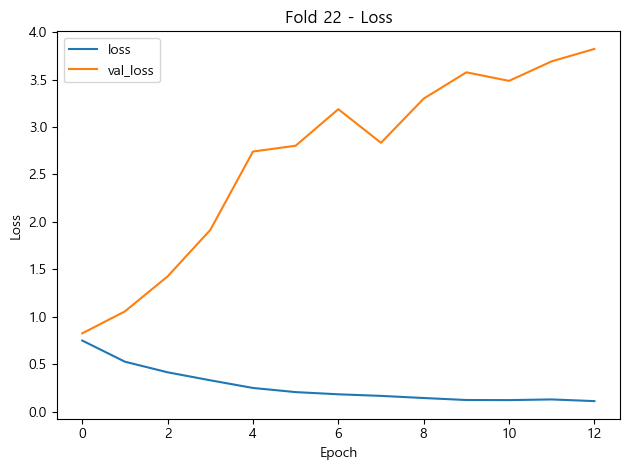

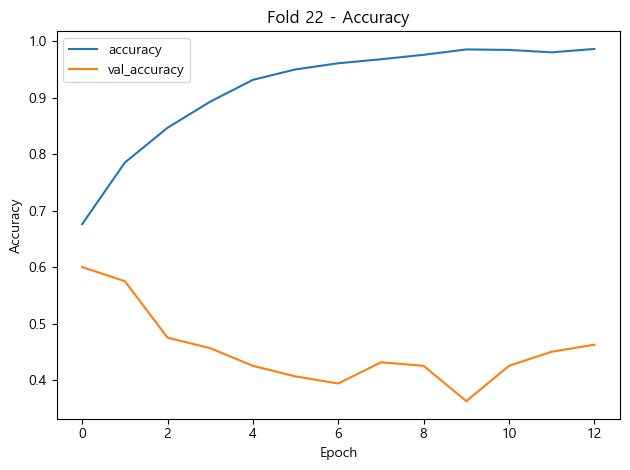


==== LOSO Summary (Up/Down) ====
Mean Window Acc: 0.787 ± 0.136
Mean Clip   Acc: 0.804 ± 0.146

==== OVERALL (클립) ====
Overall 클립 Acc: 0.799
              precision    recall  f1-score   support

           위      0.825     0.756     0.789       250
          아래      0.777     0.841     0.808       252

    accuracy                          0.799       502
   macro avg      0.801     0.799     0.798       502
weighted avg      0.801     0.799     0.798       502



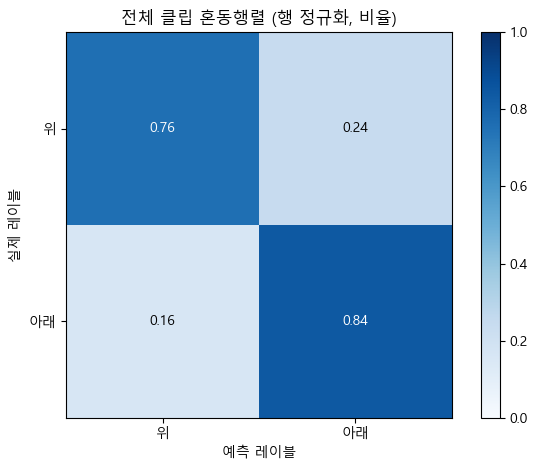

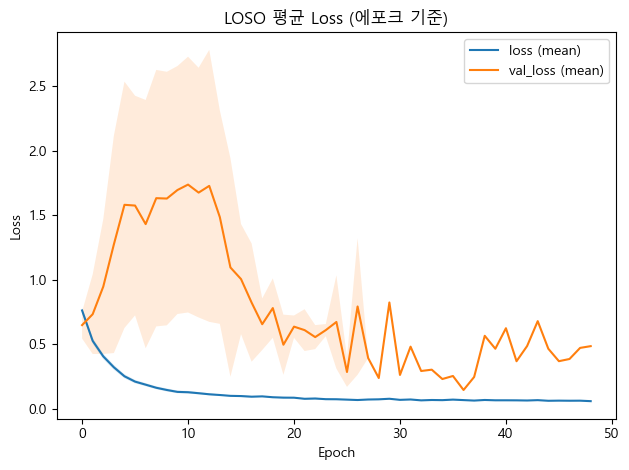

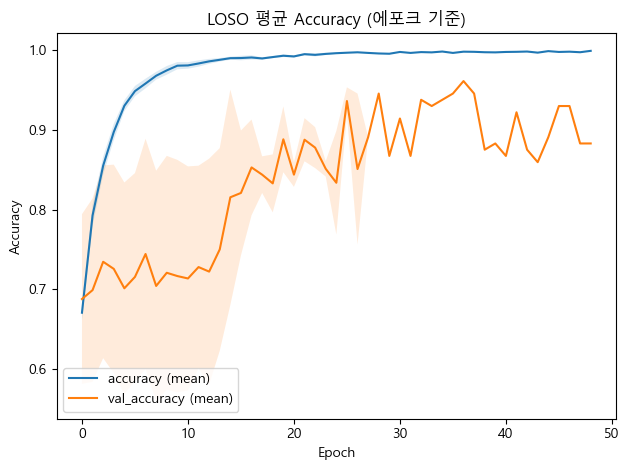

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import os

# ===== 옵션 =====
EPOCHS = 80
BATCH_SIZE = 64
ES_PATIENCE = 12
RLR_PATIENCE = 6

PLOT_LAST_FOLD_CURVES = True  # 폴드 개별 곡선(마지막 폴드만)
EVAL_LEVEL = "clip"          # "clip" 또는 "window"

# ===== 한글 폰트 =====
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

# ===== 데이터 증강 기법: Time Stretching 함수 =====
def time_stretch(data, factor=1.2):
    L, C = data.shape
    # 원본 → 늘어난 축의 인덱스
    src_x = np.arange(L)
    dst_L = max(1, int(round(L * factor)))
    dst_x = np.linspace(0, L-1, dst_L)
    stretched = np.stack([np.interp(dst_x, src_x, data[:, c]) for c in range(C)], axis=1)
    # 다시 정확히 L로 리샘플
    back_x = np.linspace(0, dst_L-1, L)
    src_x2 = np.arange(dst_L)
    data_L = np.stack([np.interp(back_x, src_x2, stretched[:, c]) for c in range(C)], axis=1)
    return data_L.astype(np.float32)


# ===== 시각화 헬퍼 =====
def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    mean_loss, std_loss          = _nanmean_along_epochs([h.get('loss', []) for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h.get('val_loss', []) for h in histories])

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy']     for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ===== 13 → 2 (위/아래) 매핑 및 데이터 필터 (가정) =====
#   - 이 부분은 외부 데이터와 변수 (X, y, meta, persons)가 정의되었다고 가정합니다.
#   - 실제 데이터셋으로 아래 변수들을 대체해야 합니다.
# KOREAN_LABELS = ['위-구개측', '아래-설측', '협측', ...]
# X = np.random.rand(100, 45, 48) # (샘플 수, 시퀀스 길이, 특징 차원)
# y = np.random.randint(0, 13, 100)
# meta = [{'person': p, 'src': f'file_{p}_{i}'} for i, p in enumerate(np.random.randint(0, 10, 100))]
# KOREAN_LABELS, X, y, meta 등 실제 데이터셋으로 대체해야 합니다.

# ... (위의 데이터 준비 코드가 여기에 위치)

# ===== 13 → 2 (위/아래) 매핑 및 데이터 필터 =====
labels_np = np.array(KOREAN_LABELS, dtype=object)

def _ud_from_label(lab: str):
    if ('구개측' in lab) or ('위-씹는면' in lab):
        return 0  # 위
    if ('설측' in lab) or ('아래-씹는면' in lab):
        return 1  # 아래
    return None   # 제외(협측 등)

keep_indices = []
y_ud_list = []
for i, yi in enumerate(y):
    lab = labels_np[yi]
    m = _ud_from_label(lab)
    if m is not None:
        keep_indices.append(i)
        y_ud_list.append(m)

keep_indices = np.array(keep_indices, dtype=int)
X_ud = X[keep_indices]
y_ud = np.array(y_ud_list, dtype=int)
meta_ud = [meta[i] for i in keep_indices]
persons_ud = np.array([m["person"] for m in meta_ud])

print(f"[Filter] 총 {len(X)}개 중 {len(X_ud)}개를 사용 (협측 제외).  위/아래 분포:", np.bincount(y_ud))

# ===== LOSO 학습/평가 루프 =====
F = X_ud.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7
logo = LeaveOneGroupOut()

CLASS_NAMES = ['위','아래']

histories = []
all_win_true, all_win_pred = [], []
all_clip_true, all_clip_pred = [], []
all_win_acc, all_clip_acc = [], []

fold_no = 0
total_folds = len(np.unique(persons_ud))

for train_idx, val_idx in logo.split(X_ud, y_ud, groups=persons_ud):
    fold_no += 1
    print(f"\n===== FOLD {fold_no}/{total_folds} - Person: {persons_ud[val_idx][0]} =====")

    # Split
    X_train, y_train = X_ud[train_idx], y_ud[train_idx]
    X_val,   y_val  = X_ud[val_idx],   y_ud[val_idx]

    # 스케일러: train으로만 fit
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    X_train_s = scaler.transform(Xtr_flat).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

    # <<<<<<<<< Time Stretching 데이터 증강 적용 >>>>>>>>>
    X_train_augmented = []
    y_train_augmented = []
    original_length = X_train_s.shape[1]

    for i in range(X_train_s.shape[0]):
        X_train_augmented.append(X_train_s[i])
        y_train_augmented.append(y_train[i])

        if np.random.rand() > 0.5:
            factor = np.random.uniform(0.85, 1.15)
            augmented_data = time_stretch(X_train_s[i], factor=factor)
            
            # 길이 통일 (중요!)
            if augmented_data.shape[0] > original_length:
                augmented_data = augmented_data[:original_length]
            else:
                padding = np.zeros((original_length - augmented_data.shape[0], augmented_data.shape[1]), dtype=np.float32)
                augmented_data = np.vstack([augmented_data, padding])

            X_train_augmented.append(augmented_data)
            y_train_augmented.append(y_train[i])

    X_train_s_aug = np.array(X_train_augmented, dtype=np.float32)
    y_train_aug = np.array(y_train_augmented, dtype=np.int32)
    
    p = np.random.permutation(len(X_train_s_aug))
    X_train_s_aug = X_train_s_aug[p]
    y_train_aug = y_train_aug[p]
    # <<<<<<<<< 데이터 증강 적용 끝 >>>>>>>>>

    # 모델
    model = build_crnn_with_delta(input_shape=(X_train_s.shape[1], X_train_s.shape[2]), n_classes=2)

    cls_counts = np.bincount(y_train_aug, minlength=2)
    class_weights = {i: float(np.median(cls_counts)/c) for i, c in enumerate(cls_counts)}

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
    ]

    history = model.fit(
        X_train_s_aug, y_train_aug,
        validation_data=(X_val_s, y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=cb, verbose=1
    )
    histories.append(history.history)

    if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
        plot_training_curves(history, fold_no)

    # 윈도우 단위 예측
    p = model.predict(X_val_s, verbose=0)
    y_pred = p.argmax(1)
    win_acc = accuracy_score(y_val, y_pred)
    all_win_acc.append(win_acc)
    all_win_true.append(y_val); all_win_pred.append(y_pred)

    # 클립 단위 예측
    bucket_p, bucket_y = defaultdict(list), {}
    val_meta = [meta_ud[i] for i in val_idx]
    for i, m in enumerate(val_meta):
        bucket_p[m["src"]].append(p[i])
        bucket_y[m["src"]] = y_val[i]
    P_clip, Y_clip = [], []
    for src, ps in bucket_p.items():
        P_clip.append(np.mean(ps, axis=0))
        Y_clip.append(bucket_y[src])
    clip_pred = np.argmax(np.vstack(P_clip), axis=1)
    clip_acc = accuracy_score(Y_clip, clip_pred)
    all_clip_acc.append(clip_acc)
    all_clip_true.append(np.array(Y_clip))
    all_clip_pred.append(clip_pred)

# ===== 폴드 전체 집계 =====
all_win_true  = np.concatenate(all_win_true, axis=0)
all_win_pred  = np.concatenate(all_win_pred, axis=0)
all_clip_true = np.concatenate(all_clip_true, axis=0)
all_clip_pred = np.concatenate(all_clip_pred, axis=0)

print("\n==== LOSO Summary (Up/Down) ====")
print(f"Mean Window Acc: {np.mean(all_win_acc):.3f} ± {np.std(all_win_acc):.3f}")
print(f"Mean Clip   Acc: {np.mean(all_clip_acc):.3f} ± {np.std(all_clip_acc):.3f}")

# ===== 최종(전체 사람) 혼동행렬/지표 =====
if EVAL_LEVEL == "clip":
    y_true_overall = all_clip_true; y_pred_overall = all_clip_pred; level_name = "클립"
else:
    y_true_overall = all_win_true;  y_pred_overall = all_win_pred;  level_name = "윈도우"

overall_acc = accuracy_score(y_true_overall, y_pred_overall)
print(f"\n==== OVERALL ({level_name}) ====")
print(f"Overall {level_name} Acc: {overall_acc:.3f}")
print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1])
plot_confmat_ratio(cm_overall, CLASS_NAMES, f'전체 {level_name} 혼동행렬 (행 정규화, 비율)')

# ===== LOSO 평균 곡선 =====
plot_mean_training_curves(histories)